# Benchmarks and results

## Benchmark environment and setup

In [1]:
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt

from tabulate import tabulate

dataset = 'youtube-40-angular'
metric = 'angular'
build_threads = [1, 2, 4, 8, 16]
libs = ('N2', 'NMSLIB')

ret = !pip3 list --format=columns | grep -e '^n2 ' | awk '{print $2}'
n2_ver = ret[-1]
ret = !pip3 list --format=columns | grep -e '^nmslib ' | awk '{print $2}'
nmslib_ver = ret[-1]

test_environment = f"""CPU: Intel Xeon E5-2620 v4
Memory: 64GB
Storage: SSD
Dataset: Youtube(5.4GB)
N2 version: {n2_ver}
NMSLIB version: {nmslib_ver}"""

## Benchmark for measuring memory usage and build time

In [2]:
%%capture capt
!rm -rf cache
!rm -rf result

for t in build_threads:
    !python3 benchmark_script.py --distance {metric} --dataset {dataset} --n_threads {t} --build_only

result = {}
for l in open(f'./result/result_{dataset}_100_3.txt'):
    _, lib_param, build_time, _, _, memory_usage = l.strip().split('\t')
    result[lib_param] = (float(build_time), float(memory_usage))

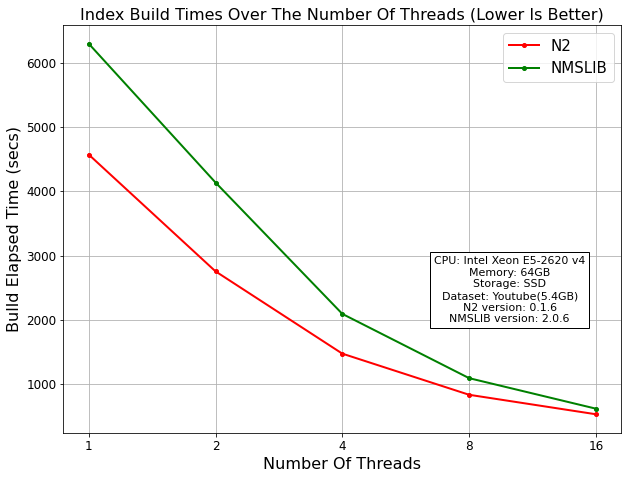

+----------------------------+-------------+-------------+-------------+-------------+--------------+
| Library                    | 1 Thread    | 2 Threads   | 4 Threads   | 8 Threads   | 16 Threads   |
+============================+=============+=============+=============+=============+==============+
| N2 (Index Size: 3.7GB)     | 4573.29 sec | 2755.25 sec | 1474.25 sec | 834.02 sec  | 530.79 sec   |
+----------------------------+-------------+-------------+-------------+-------------+--------------+
| NMSLIB (Index Size: 3.9GB) | 6299.19 sec | 4137.87 sec | 2093.01 sec | 1092.62 sec | 617.71 sec   |
+----------------------------+-------------+-------------+-------------+-------------+--------------+

N2 builds index file 14~33% faster than NMSLIB.



In [3]:
n2_build_times = []
nmslib_build_times = []
for t in build_threads:
    n2_build_times.append(result[f'N2_M12_efCon100_n_thread{t}_efSearch25'][0])
    nmslib_build_times.append(result[f'NMSLIB_M12_efCon100_n_thread{t}_efSearch25'][0])
    
fig = plt.figure(figsize=(10, 7.5))
plt.title('Index Build Times Over The Number Of Threads (Lower Is Better)', fontsize=16)
plt.ylabel('Bulld Elapsed Time (secs)', fontsize=16)
plt.xlabel('Number Of Threads', fontsize=16)
plt.text(0.8, 0.35, test_environment, color='black', 
         bbox=dict(facecolor='white', edgecolor='black'), size=11,
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes)
x = range(len(build_threads))
plt.plot(x, n2_build_times, 'ro-',label='N2', linewidth=2, ms=4)
plt.plot(x, nmslib_build_times, 'go-', label='NMSLIB', linewidth=2, ms=4)
plt.xticks(x, build_threads, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(prop={'size': 15}, loc='upper right')
plt.grid()
plt.show()

ret = !ls -hs cache/index_n2_{dataset}_M12_efCon100_n_thread{build_threads[-1]} | cut -d' ' -f1
n2_index_size = ret[0]
ret = !ls -hs cache/index_nmslib_{dataset}_M12_efCon100_n_thread{build_threads[-1]} | cut -d' ' -f1
nmslib_index_size = ret[0]

headers = ['Library']
for t in build_threads:
    if t == 1:
        headers.append(f'{t} Thread')
    else:
        headers.append(f'{t} Threads')
table = [
    [f'N2 (Index Size: {n2_index_size}B)'] + [f'{round(time, 2)} sec' for time in n2_build_times],
    [f'NMSLIB (Index Size: {nmslib_index_size}B)'] + [f'{round(time, 2)} sec' for time in nmslib_build_times]
]
print(tabulate(table, headers, tablefmt="grid"))

compare = [round((nmslib - n2) * 100 / nmslib) for n2, nmslib in zip(n2_build_times, nmslib_build_times)]

print(f'\nN2 builds index file {min(compare)}~{max(compare)}% faster than NMSLIB.\n')

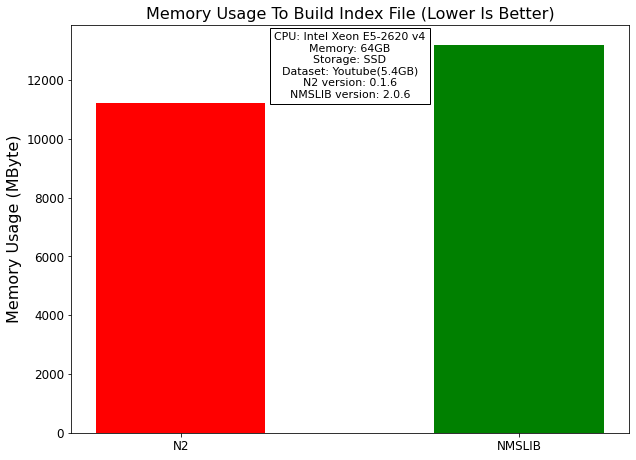

+-----------+----------------+
| Library   | Memory Usage   |
+===========+================+
| N2        | 11210.2 MB     |
+-----------+----------------+
| NMSLIB    | 13212.52 MB    |
+-----------+----------------+

N2 uses 15% less memory than NMSLIB.



In [4]:
memory_usages = [result[f'{lib}_M12_efCon100_n_thread16_efSearch25'][1] / 1024 for lib in libs]

fig = plt.figure(figsize=(10, 7.5))
y = range(len(libs))
plt.title('Memory Usage To Build Index File (Lower Is Better)', fontsize=16)
plt.ylabel('Memory Usage (MByte)', fontsize=16)
plt.bar(y, memory_usages, width = 0.5, color=['r', 'g'])
plt.xticks(y, libs, fontsize=12)
plt.yticks(fontsize=12)
plt.text(0.5, 0.9, test_environment, color='black', 
         bbox=dict(facecolor='none', edgecolor='black'), size=11,
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes)
plt.show()

headers = ['Library', 'Memory Usage']
table = [[lib, f'{round(usage, 2)} MB'] for lib, usage in zip(libs, memory_usages)]

print(tabulate(table, headers, tablefmt="grid"))

compare = round((memory_usages[1] - memory_usages[0]) * 100 / memory_usages[1])

print(f'\nN2 uses {compare}% less memory than NMSLIB.\n')

## Benchmark for measuring search performance

In [5]:
%%capture capt
!rm -rf result
!(python3 benchmark_script.py --distance {metric} --dataset {dataset} --try_count 6 --n_threads {build_threads[-1]} \
  --ef_searches 25 50 100 250 500 750 1000 1500 2500 5000 10000 50000)

In [6]:
result = defaultdict(list)
for l in open(f'./result/result_{dataset}_100_3.txt'):
    lib, lib_param, _, search_elapsed, precision, _ = l.strip().split('\t')
    result[lib].append((float(search_elapsed), float(precision), lib_param))

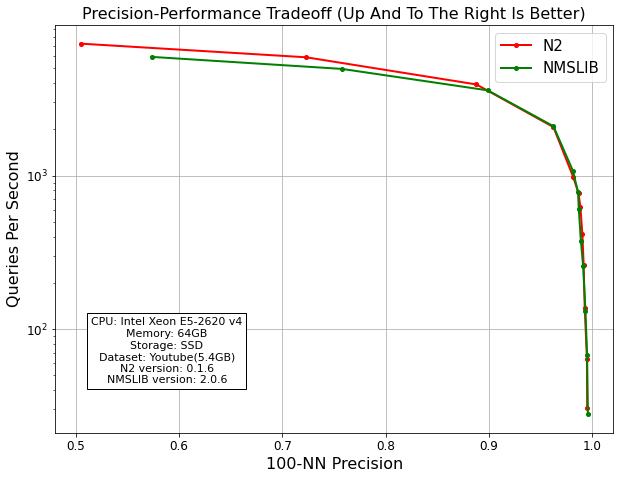

+------------------------------------+--------------------+-----------------+------------------------+---------------------+
| Parameter                          |   Search Time (N2) |   Accuracy (N2) |   Search Time (NMSLIB) |   Accuracy (NMSLIB) |
+====================================+====================+=================+========================+=====================+
| M: 12, efCon: 100, efSearch: 25    |        0.000137957 |        0.504664 |            0.000168287 |            0.573328 |
+------------------------------------+--------------------+-----------------+------------------------+---------------------+
| M: 12, efCon: 100, efSearch: 50    |        0.000169365 |        0.723281 |            0.000201599 |            0.757813 |
+------------------------------------+--------------------+-----------------+------------------------+---------------------+
| M: 12, efCon: 100, efSearch: 100   |        0.000254578 |        0.88809  |            0.000278069 |            0.898943 |


In [7]:
n2_result = sorted(result['n2'])
n2_qps = [1/r[0] for r in n2_result]
n2_precision = [r[1] for r in n2_result]

nmslib_result = sorted(result['nmslib'])
nmslib_qps = [1/r[0] for r in nmslib_result]
nmslib_precision = [r[1] for r in nmslib_result]

fig = plt.figure(figsize=(10, 7.5))
plt.title('Precision-Performance Tradeoff (Up And To The Right Is Better)', fontsize=16)
plt.ylabel('Queries Per Second', fontsize=16)
plt.xlabel('100-NN Precision', fontsize=16)
plt.text(0.20, 0.20, test_environment, color='black', 
         bbox=dict(facecolor='white', edgecolor='black'), size=11,
         horizontalalignment='center', verticalalignment='center',
         transform=plt.gca().transAxes)
plt.plot(n2_precision, n2_qps, 'ro-', label='N2', linewidth=2, ms=4)
plt.plot(nmslib_precision, nmslib_qps, 'go-', label='NMSLIB', linewidth=2, ms=4)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.yscale('log')
plt.legend(prop={'size': 15}, loc='upper right')
plt.grid()
plt.show()

headers = ['Parameter', 'Search Time (N2)', 'Accuracy (N2)', 'Search Time (NMSLIB)', 'Accuracy (NMSLIB)']
table = [[n2[2].split('_')[1].replace('M', 'M: ') + ', ' +
          n2[2].split('_')[2].replace('Con', 'Con: ') + ', ' + 
          n2[2].split('_')[5].replace('Search', 'Search: '), n2[0], n2[1], nmslib[0], nmslib[1]] 
         for n2, nmslib in zip(n2_result, nmslib_result)]
print(tabulate(table, headers, tablefmt="grid"))